In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer,roc_auc_score, roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

** Obtain data from Kaggle **

In [2]:
all_train = pd.read_csv('act_train.csv')
people = pd.read_csv('people.csv')
act_test = pd.read_csv('act_test.csv')

** Initial analysis to understand the data **

In [3]:
all_train.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [4]:
people.head(2)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76


In [5]:
all_col = list(all_train.columns)
temp = pd.DataFrame(columns=['Column Name','Unique Count','Rows Populated'])
for col,col_data in enumerate(all_col):
    t1={}
    t1['Column Name'] = col_data
    t1['Unique Count'] = len(all_train[col_data].value_counts())
    t1['Rows Populated'] = all_train[col_data].value_counts().sum()
    temp=temp.append(t1,ignore_index=True)
print temp

          Column Name  Unique Count  Rows Populated
0           people_id      151295.0       2197291.0
1         activity_id     2197291.0       2197291.0
2                date         411.0       2197291.0
3   activity_category           7.0       2197291.0
4              char_1          51.0        157615.0
5              char_2          32.0        157615.0
6              char_3          11.0        157615.0
7              char_4           7.0        157615.0
8              char_5           7.0        157615.0
9              char_6           5.0        157615.0
10             char_7           8.0        157615.0
11             char_8          18.0        157615.0
12             char_9          19.0        157615.0
13            char_10        6515.0       2039676.0
14            outcome           2.0       2197291.0


In [6]:
del temp
temp = pd.DataFrame(columns=['Column Name','Unique Count','Rows Populated'])
for col,col_data in enumerate(list(people.columns)):
    t1={}
    t1['Column Name'] = col_data
    t1['Unique Count'] = len(people[col_data].value_counts())
    t1['Rows Populated'] = people[col_data].value_counts().sum()
    temp=temp.append(t1,ignore_index=True)
print temp
del t1

   Column Name  Unique Count  Rows Populated
0    people_id      189118.0        189118.0
1       char_1           2.0        189118.0
2      group_1       34224.0        189118.0
3       char_2           3.0        189118.0
4         date        1196.0        189118.0
5       char_3          43.0        189118.0
6       char_4          25.0        189118.0
7       char_5           9.0        189118.0
8       char_6           7.0        189118.0
9       char_7          25.0        189118.0
10      char_8           8.0        189118.0
11      char_9           9.0        189118.0
12     char_10           2.0        189118.0
13     char_11           2.0        189118.0
14     char_12           2.0        189118.0
15     char_13           2.0        189118.0
16     char_14           2.0        189118.0
17     char_15           2.0        189118.0
18     char_16           2.0        189118.0
19     char_17           2.0        189118.0
20     char_18           2.0        189118.0
21     cha

** Further analysis of activity file to decide data preprocess requirement **

In [7]:
del temp
temp = pd.DataFrame(columns=['Column Name','Unique Count','Rows Populated'])
for col,col_data in enumerate(list(act_test.columns)):
    t1={}
    t1['Column Name'] = col_data
    t1['Unique Count'] = len(act_test[col_data].value_counts())
    t1['Rows Populated'] = act_test[col_data].value_counts().sum()
    temp=temp.append(t1,ignore_index=True)
print temp

          Column Name  Unique Count  Rows Populated
0           people_id       37823.0        498687.0
1         activity_id      498687.0        498687.0
2                date         411.0        498687.0
3   activity_category           7.0        498687.0
4              char_1          48.0         40092.0
5              char_2          31.0         40092.0
6              char_3          11.0         40092.0
7              char_4           7.0         40092.0
8              char_5           6.0         40092.0
9              char_6           5.0         40092.0
10             char_7           8.0         40092.0
11             char_8          18.0         40092.0
12             char_9          19.0         40092.0
13            char_10        3961.0        458595.0


In [8]:
print all_train['outcome'].value_counts()

0    1221794
1     975497
Name: outcome, dtype: int64


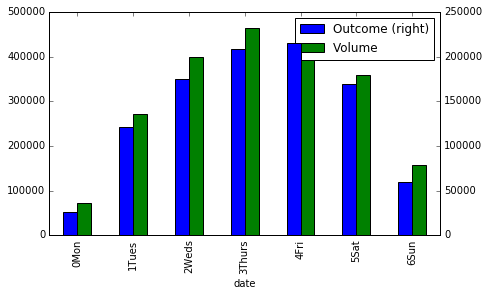

In [9]:
days = {0:'0Mon',1:'1Tues',2:'2Weds',3:'3Thurs',4:'4Fri',5:'5Sat',6:'6Sun'}
date_analysis = pd.DataFrame()
date_analysis = date_analysis.append(all_train)
date_analysis['date']=pd.to_datetime(date_analysis['date']).dt.dayofweek.apply(lambda x: days[x])
dates = pd.DataFrame()
dates['Outcome'] = date_analysis.groupby('date')['outcome'].sum()
dates['Volume'] = date_analysis.groupby('date')['outcome'].size()
dates.plot.bar(secondary_y='Outcome', linewidth=1,figsize=(7, 4),stacked=False)
del date_analysis

** Preprocess the data **

** categorize the date columns **

** Merge data **

In [10]:
people_act = pd.merge(all_train,people,on='people_id')
people_act_test = pd.merge(act_test,people,on='people_id')

In [11]:
people_act.head(2)

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36


In [12]:
people_act['date_x']=pd.to_datetime(people_act['date_x']).dt.dayofweek
people_act['date_y']=pd.to_datetime(people_act['date_y']).dt.dayofweek

In [13]:
full_col=list(people_act.columns)
features= full_col

** Convert all categorical data to numeric **

In [14]:
pact1= people_act[features].fillna('type')

In [15]:
for col, col_data in enumerate(features):
    #print col,col_data,'\t'
    if pact1[col_data].dtype == object:
        pact1[col_data] = pact1[col_data].map(lambda x: x.strip('type ').strip('group '))
    else:
        if pact1[col_data].dtype == bool:
            pact1[col_data] = pact1[col_data].map(lambda x: 1 if x =='true' else 0)

In [16]:
pact1.head(2)

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,l_100,act2_1734928,5,4,,,,,,,...,0,0,0,0,0,0,0,0,0,36
1,l_100,act2_2434093,1,2,,,,,,,...,0,0,0,0,0,0,0,0,0,36


** Cleverly remove the row identifiers by indexing them so that we will not lose track of the data ** 

In [17]:
pacts = pact1.set_index(['people_id','activity_id'])
pactx = pacts.apply(pd.to_numeric, errors='coerce').fillna(-1)

In [18]:
pactx.head(2)

date_x  activity_category  char_1_x  char_2_x  \
people_id activity_id                                                   
l_100     act2_1734928       5                  4      -1.0      -1.0   
          act2_2434093       1                  2      -1.0      -1.0   

                        char_3_x  char_4_x  char_5_x  char_6_x  char_7_x  \
people_id activity_id                                                      
l_100     act2_1734928      -1.0      -1.0      -1.0      -1.0      -1.0   
          act2_2434093      -1.0      -1.0      -1.0      -1.0      -1.0   

                        char_8_x   ...     char_29  char_30  char_31  char_32  \
people_id activity_id              ...                                          
l_100     act2_1734928      -1.0   ...           0        0        0        0   
          act2_2434093      -1.0   ...           0        0        0        0   

                        char_33  char_34  char_35  char_36  char_37  char_38  
people_id activity_id                                                         
l_100     act2_1734928        0        0        0        0        0       36  
          act2_2434093        0        0        0        0        0       36  

[2 rows x 53 columns]

** Separate the data into features and target values so that they can be used as input to sklearn **

In [19]:
features1 = list(pacts.columns)
features1.remove('outcome')
X_all = pactx[features1]
y_all = pactx['outcome']
print X_all.shape
print y_all.shape

(2197291, 52)
(2197291L,)


** Split combined dataset to train and test **

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=.20, random_state=0)

In [21]:
print y_train.value_counts() # to confirm stratified split
print y_test.value_counts()

0    977580
1    780252
Name: outcome, dtype: int64
0    244214
1    195245
Name: outcome, dtype: int64


** Helper functions to run multiple models and measure performance **

In [22]:
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    train_time = end - start
    return train_time
    
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict_proba(features)[:,1]
    fpr,tpr,_ = roc_curve(target.values, y_pred)
    score = roc_auc_score(target.values, y_pred)
    end = time.time()
    pred_time = end - start
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return fpr,tpr,score,pred_time

def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_time = train_classifier(clf, X_train, y_train)
    fpr,tpr,score,pred_time = predict_labels(clf, X_train, y_train)
    fprt,tprt,scoret,pred_timet = predict_labels(clf, X_test, y_test)
    print "ROC AUC score for training set: {}".format(score)
    print "ROC AUC score for test set: {}".format(scoret)
    return fprt, tprt, score, scoret, train_time, pred_time, pred_timet

In [23]:
feature3=['group_1','char_2_y','char_38','char_3_y','char_4_y','char_5_y','char_6_y','char_7_y','char_8_y',
          'date_x','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x',
          'char_6_x','char_7_x','char_8_x','char_9_x','char_10_x']
feature1 = features1[:]

** Initial model with the entire features and set as initial Benchmark**

In [24]:
clf_benchmark = LogisticRegression()
fprb,tprb,scoreb,scorebt,train_timeb,pred_timeb,pred_timetb=train_predict(clf_benchmark,X_train, y_train,X_test,y_test)

------------------------------------------
Training set size: 1757832
Training LogisticRegression...
Done!
Training time (secs): 61.729
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 2.771
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.529
ROC AUC score for training set: 0.892215703917
ROC AUC score for test set: 0.892446649781


In [25]:
clf0 = RandomForestClassifier()
fpr0,tpr0,score0,score0t,train_time0,pred_time0,pred_timet0=train_predict(clf0,X_train, y_train,X_test,y_test)

------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 66.419
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 10.133
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 2.063
ROC AUC score for training set: 0.999374389531
ROC AUC score for test set: 0.994299103141


** Fine tune with feature set feature3 of select features **

In [26]:
clf1 = RandomForestClassifier()
fpr1,tpr1,score1,score1t,train_time1,pred_time1,pred_timet1=train_predict(clf1,X_train[feature3], y_train,X_test[feature3],y_test)

------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 65.032
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 7.288
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 1.845
ROC AUC score for training set: 0.999373481993
ROC AUC score for test set: 0.994891418242


** Final model with max_features parameters **

In [27]:
clf2 = RandomForestClassifier(max_features=20)
fpr2,tpr2,score2,scoret,train_time2,pred_time2,pred_timet2=train_predict(clf2,X_train, y_train,X_test,y_test)

------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 116.701
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 6.889
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 1.749
ROC AUC score for training set: 0.999472080009
ROC AUC score for test set: 0.995445726242


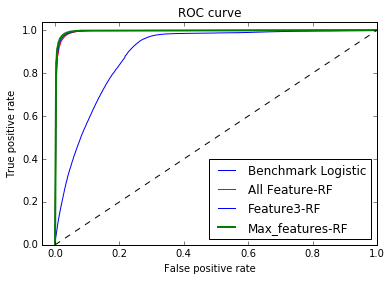

In [28]:
#fpr=list(bench_mark[['fpr']].ix[0].values)
#tpr=list(bench_mark[['tpr']].ix[0].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(-.04, 1.0)
plt.ylim(0, 1.04)
plt.plot(fprb,tprb,color='b',label='Benchmark Logistic')
plt.plot(fpr0,tpr0,color='r',label='All Feature-RF')
plt.plot(fpr1,tpr1,color='b',label='Feature3-RF')
plt.plot(fpr2,tpr2,color='g',linewidth=2,label='Max_features-RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

** Preprocess the test data (the third file without target values provided by Kaggle) for final submission to Kaggle **

In [29]:
people_act_test['date_x']=pd.to_datetime(people_act_test['date_x']).dt.dayofweek
people_act_test['date_y']=pd.to_datetime(people_act_test['date_y']).dt.dayofweek

In [30]:
features2=list(people_act_test.columns)
pact2= people_act_test[features2].fillna('type')
for col, col_data in enumerate(features2):
    #print col,col_data
    if pact2[col_data].dtype == object:
        pact2[col_data] = pact2[col_data].map(lambda x: x.strip('type ').strip('group '))
    else:
        if pact2[col_data].dtype == bool:
            pact2[col_data] = pact2[col_data].map(lambda x: 1 if x =='true' else 0)

In [31]:
pact2.head(2)

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,l_100004,act1_249281,2,1,5,10,5,1,6,1,...,0,0,0,0,0,0,0,0,0,76
1,l_100004,act2_230855,2,5,,,,,,,...,0,0,0,0,0,0,0,0,0,76


In [32]:
pacts2 = pact2.set_index(['people_id','activity_id'])
pactx2 = pacts2.apply(pd.to_numeric, errors='coerce').fillna(-1)

In [33]:
featurex = list(pactx2.columns)
featurex.remove('date_y')
featurex.remove('date_x')

** Create predicted output for the test file **

In [34]:
yfinal_pred = clf2.predict_proba(pactx2)[:,1]
print yfinal_pred[0:40]

[ 0.6   0.5   0.9   0.8   0.9   0.9   0.9   0.9   0.9   1.    0.9   0.9
  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9
  0.9   0.9   1.    0.    0.    0.    0.    0.9   0.9   0.9   0.9   0.9
  0.9   0.8   0.9   0.89]


** Create the final file to be submitted **

In [35]:
sub = pd.DataFrame()
sub['activity_id'] = pact2['activity_id']
sub['pred_outcome'] = yfinal_pred
sub.to_csv('Redhat_sub.csv')

** Populate the result comparison of various models **

In [36]:
bench_mark = pd.DataFrame()
test_features = [feature1,feature3]
clflist = [clf0,clf1,clf2]
for clf in clflist:
    for x in test_features:
        fprt,tprt,score,scoret,train_time,pred_time,pred_timet=train_predict(clf,X_train[x], y_train,X_test[x],y_test)
        bm = {}
        bm['fpr'] = fprt
        bm['tpr'] = tprt
        bm['AUC Train'] = score
        bm['AUC Test'] = scoret
        bm['Train Time'] = train_time
        bm['Pred Time Train'] = pred_time
        bm['Pred Time Test'] = pred_timet
        bm['features'] = x
        bm['classifier'] = clf.__class__.__name__
        bench_mark = bench_mark.append(bm,ignore_index=True)

------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 65.670
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 8.571
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 2.364
ROC AUC score for training set: 0.999366087899
ROC AUC score for test set: 0.99424070087
------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 67.398
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 7.308
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 1.844
ROC AUC score for training set: 0.999372334948
ROC AUC score for test set: 0.994856829684
------------------------------------------
Training set size: 1757832
Training RandomForestClassifier...
Done!
Training time (secs): 66.058
Predicting labels using RandomForestClassifier...
Done!
P

In [37]:
bench_mark[['features','AUC Test','AUC Train','Pred Time Test','Pred Time Train','Train Time']]

,features,AUC Test,AUC Train,Pred Time Test,Pred Time Train,Train Time
0,"[date_x, activity_category, char_1_x, char_2_x...",0.994241,0.999366,2.364,8.571,65.670
1,"[group_1, char_2_y, char_38, char_3_y, char_4_...",0.994857,0.999372,1.844,7.308,67.398
2,"[date_x, activity_category, char_1_x, char_2_x...",0.994109,0.999363,2.152,8.569,66.058
3,"[group_1, char_2_y, char_38, char_3_y, char_4_...",0.994786,0.999369,1.889,8.400,65.344
4,"[date_x, activity_category, char_1_x, char_2_x...",0.995493,0.999473,1.745,6.934,118.041
5,"[group_1, char_2_y, char_38, char_3_y, char_4_...",0.995417,0.999453,1.536,5.872,219.399


** Free form visualization **

In [38]:
date_analysis1 = pd.DataFrame()
date_analysis1 = date_analysis1.append(all_train)
date_analysis1['month']=pd.to_datetime(date_analysis1['date']).dt.month
date_analysis1['year']=pd.to_datetime(date_analysis1['date']).dt.year

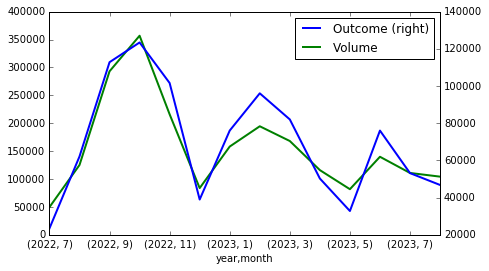

In [39]:
dates1 = pd.DataFrame()
dates1['Outcome'] = date_analysis1.groupby(['year','month'])['outcome'].sum()
dates1['Volume'] = date_analysis1.groupby(['year','month'])['outcome'].size()
dates1.plot(secondary_y='Outcome', linewidth=2,figsize=(7, 4),stacked=False)
del date_analysis1